<a href="https://colab.research.google.com/github/valerian-drmt/Trading_Projects/blob/main/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Install/Import Libraries

In [46]:
!pip install vectorbt

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import norm
import plotly.express as px
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [80]:
codelab = False
if codelab:
    from google.colab import files

    # Choisis ton fichier à uploader
    uploaded = files.upload()

# 2) Features Class

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

### 🕒 Market Opening Hours (Paris Time)

| Market     | Opening Hours (Paris Time) | Opening Hours (UTC) |
|------------|-----------------------------|----------------------|
| 🇭🇰 **Hong Kong / Tokyo** | 01:00 – 07:00                    | 00:00 – 06:00         |
| 🇬🇧 **London**            | 09:00 – 17:30                    | 08:00 – 16:30         |
| 🇺🇸 **New York**          | 15:30 – 22:00                    | 13:30 – 20:00         |

> ⚠️ Note: Hours may shift by 1 hour during daylight saving time transitions.

In [178]:
class LSTM_Features:
    def __init__(self, symbols: str, start: str, end: str, interval: str):
        self.symbols = symbols
        self.start = start
        self.end = end
        self.interval = interval
        self.data = None
    
    def Get_Excel_from_API(self):
        data_request = vbt.BinanceData.download(
            symbols= self.symbols,
            start = self.start,
            end = self.end,
            interval = self.interval,
        )

        # Extraire les données OHLCV sous forme de DataFrame
        df = data_request.get()

        print(df.index[0])
        print(df.head())

        # Make sure the index is timezone-naive
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

        # Also remove timezone from datetime columns (if any)
        for col in df.columns:
            if pd.api.types.is_datetime64tz_dtype(df[col]):
                df[col] = df[col].dt.tz_localize(None)

        # Save to Excel
        df.to_excel("BTCUSDT_5m.xlsx", index=True)
        print("BTCUSDT_5m.xlsx is in the folder")

    def EXCEL_load_data(self):
        self.data = pd.read_excel("BTCUSDT_5m.xlsx")
        return self
    
    def extend_OHLC(self):
        rows = [{
            "Open time": self.data.iloc[0]["Open time"],
            "Price": self.data.iloc[0]["Open"],
            "Volume": self.data.iloc[0]["Volume"] / 4
        }]

        for _, row in self.data.iterrows():
            t, o, h, l, c, v = row["Open time"], row["Open"], row["High"], row["Low"], row["Close"], row["Volume"]
            v_row = v / 3

            if o >= c:
                values = [h, l, c]
            else:
                values = [l, h, c]

            for value in values:
                rows.append({
                    "Open time": t,
                    "Price": value,
                    "Volume": v_row
                })

        self.data = pd.DataFrame(rows)
        self.data.set_index("Open time", inplace=True)
        return self
    
    def market_sessions(self):
        # Make sure datetime index is correct
        self.data.index = pd.to_datetime(self.data.index)
        self.data.index = self.data.index.tz_localize(None)

        # Functions to check sessions
        def is_london_open(hour, minute):
            return (9 < hour < 17) or (hour == 17 and minute <= 30)

        def is_ny_open(hour, minute):
            return (16 <= hour < 22) or (hour == 15 and minute >= 30) or (hour == 22 and minute == 0)

        def is_tokyo_open(hour, minute):
            return (1 <= hour < 7)

        # Directly create session flags
        self.data['London_Open'] = self.data.index.map(lambda ts: int(is_london_open(ts.hour, ts.minute)))
        self.data['NY_Open'] = self.data.index.map(lambda ts: int(is_ny_open(ts.hour, ts.minute)))
        self.data['HK_Open'] = self.data.index.map(lambda ts: int(is_tokyo_open(ts.hour, ts.minute)))
        
        return self

#----------------------------------------------------------------------
#----------------------------------------------------------------------

After market_sessions():
                        Price     Volume  London_Open  NY_Open  HK_Open
Open time                                                              
2024-03-09 22:00:00  68376.13  13.178735            0        1        0
2024-03-09 22:00:00  68381.04  17.571647            0        1        0
2024-03-09 22:00:00  68333.33  17.571647            0        1        0
2024-03-09 22:00:00  68375.96  17.571647            0        1        0
2024-03-09 22:05:00  68371.03   7.409820            0        0        0
Index(['Price', 'Volume', 'London_Open', 'NY_Open', 'HK_Open'], dtype='object')
Shape: (35425, 5)

Session Open/Close Frequency:
   London_Open  NY_Open  HK_Open
0        24232    25707    26569
1        11193     9718     8856


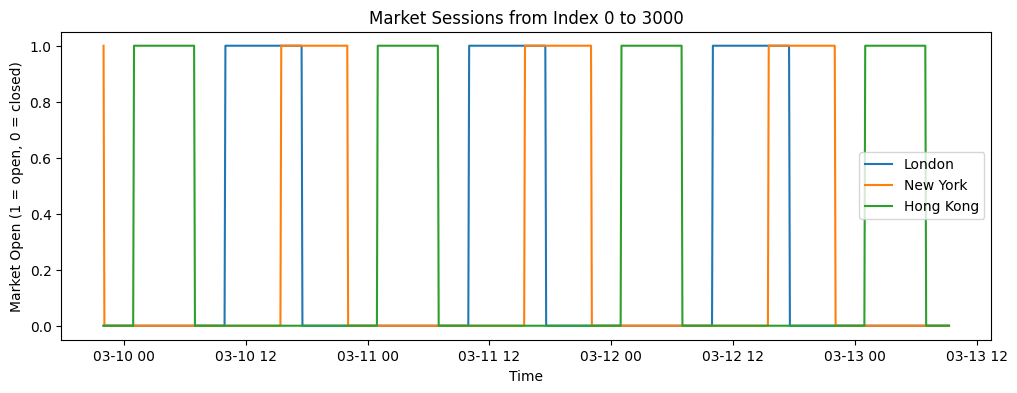

#----------------------------------------------------------------------


In [179]:
debug1 = False
debug2 = False
debug3 = True


Features_Data = LSTM_Features(symbols="BTCUSDT", start="2024-03-10", end="2024-04-20", interval="5m")

# Step 0: Get Excel from API
#Features_Data.Get_Excel_from_API()

# Step 1: Load data from Excel
Features_Data.EXCEL_load_data()

if debug1:
    print("\nAfter EXCEL_load_data():")
    print(Features_Data.data.head())
    print(Features_Data.data.columns)
    print("Shape:", Features_Data.data.shape)
print("#----------------------------------------------------------------------")
# Step 2: Extend OHLC
Features_Data.extend_OHLC()

if debug2:
    print("\nAfter extend_OHLC():")
    print(Features_Data.data.head())
    print(Features_Data.data.columns)
    print("Shape:", Features_Data.data.shape)
print("#----------------------------------------------------------------------")
# Step 3: Market Sessions
Features_Data.market_sessions()

if debug3:
    print("\nAfter market_sessions():")
    print(Features_Data.data.head())
    print(Features_Data.data.columns)
    print("Shape:", Features_Data.data.shape)

    # Additional Analysis
    frequency = Features_Data.data[["London_Open", "NY_Open", "HK_Open"]].apply(
        lambda col: pd.Series(col).value_counts()
    ).fillna(0).astype(int)
    print("\nSession Open/Close Frequency:")
    print(frequency)

    # Plotting
    nb = 3000
    plt.figure(figsize=(12, 4))
    plt.plot(Features_Data.data["London_Open"].iloc[:nb], label="London")
    plt.plot(Features_Data.data["NY_Open"].iloc[:nb], label="New York")
    plt.plot(Features_Data.data["HK_Open"].iloc[:nb], label="Hong Kong")
    plt.legend()
    plt.title(f"Market Sessions from Index 0 to {nb}")
    plt.xlabel("Time")
    plt.ylabel("Market Open (1 = open, 0 = closed)")
    plt.show()
print("#----------------------------------------------------------------------")

# Last Step: Refresh Data
Features_Data.data = None 

# 3) Labels Class

In [207]:
class LSTM_Labels():
    def __init__(self, data , look_forward :int, n_categories : int):
        self.data = data
        self.look_forward = look_forward
        self.n_categories = n_categories
        self.boundaries = None

    def categorize_based_on_std(self):

        # 1. Calculate the Return and the Z-Score
        self.data["Return"] = self.data["Price"].shift(-self.look_forward) / self.data["Price"] - 1
        mean = self.data["Return"].mean()
        std = self.data["Return"].std()
        self.data["Return Z-Score"] = (self.data["Return"] - mean) / std

        # 2. Define category boundaries based on standard deviation multiples
        n = self.n_categories
        max_std = 3  # Cover most of the normal distribution (-3σ to +3σ)
        self.boundaries = np.linspace(-max_std, max_std, n + 1)
   

        # 3. Calculate frequencies assuming normal distribution
        category_frequencies = []
        for i in range(len(self.boundaries) - 1):
            prob = norm.cdf(self.boundaries[i + 1]) - norm.cdf(self.boundaries[i])
            category_frequencies.append(prob)

        category_frequencies = np.array(category_frequencies)

        # 4. Function to categorize a Z-score
        def categorize_zscore(z, bounds):
            if pd.isna(z):
                return np.nan
            for i in range(len(bounds) - 1):
                if bounds[i] <= z < bounds[i + 1]:
                    return i
            return np.nan  # In case z is outside boundaries due to numerical issues

        # 5. Create Category_Close (current Return Z-Score category)
        self.data["Category_Close"] = self.data["Return Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))

        # 6. Calculate High and Low Z-Scores over the past 20 candles
        self.data["High_20"] = self.data["Price"].rolling(window=20).max()
        self.data["Low_20"] = self.data["Price"].rolling(window=20).min()

        self.data["High_20_Return"] = self.data["High_20"].shift(-self.look_forward) / self.data["Price"] - 1
        self.data["Low_20_Return"] = self.data["Low_20"].shift(-self.look_forward) / self.data["Price"] - 1

        self.data["High_20_Z-Score"] = (self.data["High_20_Return"] - mean) / std
        self.data["Low_20_Z-Score"] = (self.data["Low_20_Return"] - mean) / std

        # 7. Create Category_High and Category_Low
        self.data["Category_High"] = self.data["High_20_Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))
        self.data["Category_Low"] = self.data["Low_20_Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))

        # 8. Clean up intermediate columns if you want (optional)
        self.data.drop(columns=["Return", "Return Z-Score", "High_20", "Low_20", "High_20_Return", "Low_20_Return", "High_20_Z-Score", "Low_20_Z-Score"], inplace=True)

        return self

                        Price     Volume  London_Open  NY_Open  HK_Open
Open time                                                              
2024-03-09 22:00:00  68376.13  13.178735            0        1        0
2024-03-09 22:00:00  68381.04  17.571647            0        1        0
2024-03-09 22:00:00  68333.33  17.571647            0        1        0
2024-03-09 22:00:00  68375.96  17.571647            0        1        0
2024-03-09 22:05:00  68371.03   7.409820            0        0        0
                        Price     Volume  London_Open  NY_Open  HK_Open  \
Open time                                                                 
2024-03-09 22:00:00  68376.13  13.178735            0        1        0   
2024-03-09 22:00:00  68381.04  17.571647            0        1        0   
2024-03-09 22:00:00  68333.33  17.571647            0        1        0   
2024-03-09 22:00:00  68375.96  17.571647            0        1        0   
2024-03-09 22:05:00  68371.03   7.409820      

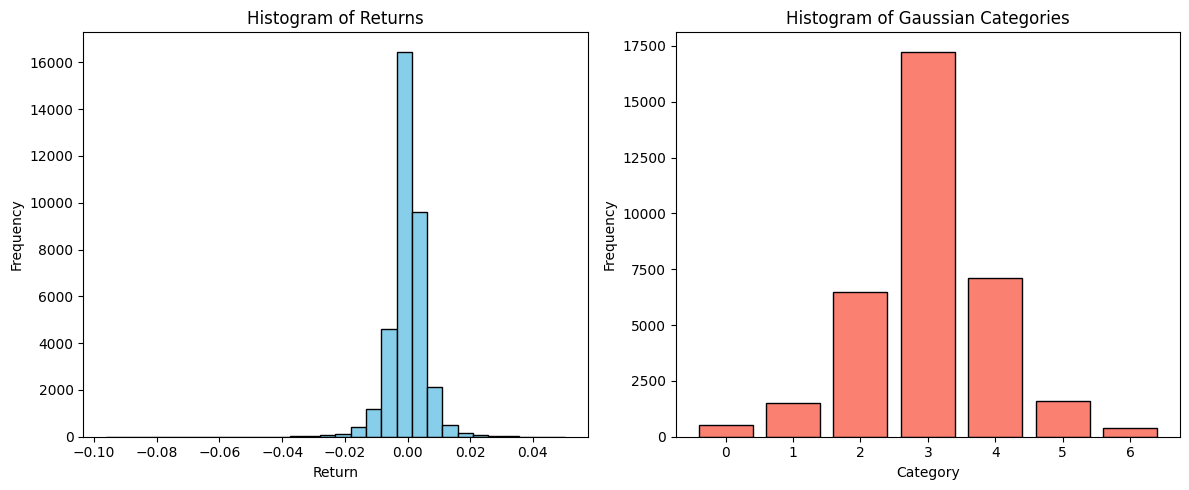

In [208]:
Features_Data = LSTM_Features(symbols="BTCUSDT", start="2024-03-10", end="2024-04-20", interval="5m").EXCEL_load_data().extend_OHLC().market_sessions()
print(Features_Data.data.head())  

#------------------------------------------------------------------------

Labels_Data = LSTM_Labels(Features_Data.data, look_forward = 20, n_categories = 7)

Labels_Data.categorize_based_on_std()

print(Labels_Data.data.head())
print("Boudaries: ", Labels_Data.boundaries)

# Count the number of points (no normalization)
close_counts = Labels_Data.data["Category_Close"].value_counts(normalize=False).sort_index()
high_counts = Labels_Data.data["Category_High"].value_counts(normalize=False).sort_index()
low_counts = Labels_Data.data["Category_Low"].value_counts(normalize=False).sort_index()
table = pd.DataFrame({
    'Low Count': low_counts.values,
    'Close Count': close_counts.values,
    'High Count': high_counts.values
}, index=close_counts.index)
print(table)

# Verification
plt.figure(figsize=(12, 5))

# Histogramme des future returns
plt.subplot(1, 2, 1)
plt.hist(Labels_Data.data["Price"].pct_change(Labels_Data.look_forward).dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")

# Histogramme des catégories gaussiennes
plt.subplot(1, 2, 2)
plt.hist(Labels_Data.data["Category_Close"].dropna(), bins=np.arange(Labels_Data.n_categories + 1) - 0.5, color='salmon', edgecolor='black', rwidth=0.8)
plt.xticks(range(Labels_Data.n_categories))
plt.title("Histogram of Gaussian Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# 4) Generate Train and Test Data

In [182]:
# @title
def split_data(train_test_data, lookback, size_test_prct):
    # 1. Split automatically: features = columns starting with "Feature_", labels = columns starting with "Label_"
    feature_cols = [col for col in train_test_data.columns if col.startswith("Feature")]
    label_cols = [col for col in train_test_data.columns if col.startswith("Label")]

    # 2. Convert to numpy arrays
    features = train_test_data[feature_cols].values  # shape (N, n_features)
    labels = train_test_data[label_cols].values      # shape (N, n_labels)

    # 3. Normalize only the features (per feature column)
    features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))

    # 4. Stack features and labels together
    data_all = np.hstack((features, labels))  # shape (N, n_features + n_labels)

    # 5. Create sequences
    data = []
    for index in range(len(data_all) - lookback):
        data.append(data_all[index: index + lookback])

    data = np.array(data)  # shape (num_sequences, lookback, n_features + n_labels)

    # 6. Split train / test
    test_set_size = int(np.round(size_test_prct * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    # ➔ x = all features
    # ➔ y = all labels
    x_train = data[:train_set_size, :, :len(feature_cols)]    # Take only features
    y_train = data[:train_set_size, -1, len(feature_cols):]    # Take only labels (last time step)
    x_test = data[train_set_size:, :, :len(feature_cols)]
    y_test = data[train_set_size:, -1, len(feature_cols):]

    # 7. Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test

# 5) LSTM Class

In [251]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, n_labels, n_categories):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList()
        self.num_epochs = num_epochs
        self.n_labels = n_labels
        self.n_categories = n_categories
        
        self.criterion = None

        # Now use LISTS to allow .append()
        self.hist_criterion = []
        self.hist_acc = []
        self.hist_f1 = []
        self.hist_precision = []
        self.hist_recall = []

        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim[0], batch_first=True))
        for i in range(1, self.num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_dim[i-1], hidden_dim[i], batch_first=True))

        self.fc = nn.Linear(hidden_dim[-1], output_dim)



    def forward(self, x):
        out = x
        for lstm in self.lstm_layers:
            out, _ = lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def update_metrics(self, y_train_pred, y_train):

        total_loss = 0
        y_pred_list = []
        y_true_list = []
        
        for i in range(self.n_labels):
            pred = y_train_pred[:, i*self.n_categories:(i+1)*self.n_categories]
            true = y_train[:, i]
            loss = self.criterion(pred, true)
            total_loss += loss / self.n_labels

            pred_classes = torch.argmax(pred, dim=1)
            y_pred_list.append(pred_classes.detach().cpu().numpy())
            y_true_list.append(true.detach().cpu().numpy())

        # Concatenate all predictions and truths
        y_pred_np = np.concatenate(y_pred_list)
        y_true_np = np.concatenate(y_true_list)

        acc = accuracy_score(y_true_np, y_pred_np)
        f1 = f1_score(y_true_np, y_pred_np, average='weighted')
        prec = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        rec = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

        self.hist_criterion.append(total_loss.item())
        self.hist_acc.append(acc)
        self.hist_f1.append(f1)
        self.hist_precision.append(prec)
        self.hist_recall.append(rec)

        return total_loss
    
    def get_pred(self,x_test):
        self.eval()
        with torch.no_grad():
            y_test_pred_list = self(x_test)  # shape (batch_size, 15)

        y_test_pred = []
        for i in range(self.n_labels):
            pred = y_test_pred_list[:, i * self.n_categories : (i+1) * self.n_categories]
            pred_class = torch.argmax(pred, dim=1)
            y_test_pred.append(pred_class)

        y_test_pred = torch.stack(y_test_pred, dim=1)  # shape (batch_size, n_labels)

        return y_test_pred,y_test_pred_list
    
    def show_metrics(self, y_test, y_test_pred, y_test_pred_list):
        # Conversion en NumPy
        y_test_np = y_test.detach().cpu().numpy()
        y_test_np = np.concatenate([y_test_np[:, i] for i in range(self.n_labels)])

        print("Shape of y_test_pred:", y_test_pred.shape)
        print("Expected output_dim:", self.n_labels * self.n_categories)

        y_pred_classes = []
        for i in range(self.n_labels):
            start_idx = i * self.n_categories
            end_idx = (i + 1) * self.n_categories

            if end_idx > y_test_pred.shape[1]:
                raise ValueError(f"Invalid slicing: trying to slice {start_idx}:{end_idx} but prediction dim is {y_test_pred.shape[1]}")

            pred = y_test_pred[:, start_idx:end_idx]
            pred_classes = torch.argmax(pred, dim=1)
            y_pred_classes.append(pred_classes.detach().cpu().numpy())

        # 🚨 Now concatenate predictions
        y_pred_np = np.concatenate(y_pred_classes)

        # Métriques test
        acc_test = accuracy_score(y_test_np, y_pred_np)
        f1_test = f1_score(y_test_np, y_pred_np, average='weighted')
        precision_test = precision_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
        recall_test = recall_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
        loss_test = self.criterion(y_test_pred_list, y_test).item()

        # Moyenne des métriques train
        acc_train = np.mean(self.hist_acc[-int(self.num_epochs * 0.2):])
        f1_train = np.mean(self.hist_f1[-int(self.num_epochs * 0.2):])
        precision_train = np.mean(self.hist_precision[-int(self.num_epochs * 0.2):])
        recall_train = np.mean(self.hist_recall[-int(self.num_epochs * 0.2):])
        loss_train = np.mean(self.hist_criterion[-int(self.num_epochs * 0.2):])

        # Tableau final
        metrics_data = {
            'Train': [acc_train, f1_train, precision_train, recall_train, loss_train],
            'Test':  [acc_test, f1_test, precision_test, recall_test, loss_test]
        }

        metrics_df = pd.DataFrame(metrics_data, index=['Accuracy', 'F1-score', 'Precision', 'Recall', 'Loss'])

        print("\n📊 Résumé des métriques de classification :\n")
        print(metrics_df.round(4))

        print("---------------------------------")
        print("Accuracy = proportion de prédictions correctes sur l’ensemble des classes.")
        print("Precision = parmi les prédictions positives, combien sont réellement correctes.")
        print("Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.")
        print("F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.")
        print("Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.")
        print("---------------------------------")

        # Plot Metrics
        metrics = [self.hist_acc, self.hist_f1, self.hist_precision, self.hist_recall, self.hist_criterion]
        titles = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'CrossEntropy Loss']
        colors = ['blue', 'green', 'orange', 'purple', 'red']
        ylabel = ['Score'] * 4 + ['Loss']

        epochs = range(1, len(self.hist_acc) + 1)
        fig, axs = plt.subplots(1, 5, figsize=(22, 4))

        for i, ax in enumerate(axs):
            ax.plot(epochs, metrics[i], color=colors[i])
            ax.set_title(titles[i])
            ax.set_xlabel('Epoch')
            ax.set_ylabel(ylabel[i])
            ax.grid(True)

        plt.tight_layout()
        plt.suptitle('Training Metrics per Epoch', fontsize=16, y=1.05)
        plt.show()

        return self

# Category Visualisation Class

In [68]:
# @title
def visualize_classification_results(y_true, y_pred, output_dim, sequence_title="True vs Predicted", max_points=150):
    """
    Affiche :
    - Matrice de confusion (heatmap)
    - Séquence de classes (true vs pred) sur les derniers points
    - Histogramme de distribution des classes

    Compatible avec Google Colab / Jupyter
    """

    # Convertir en NumPy si Tensor
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    # Créer la figure avec 3 sous-graphes côte à côte
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    plt.subplots_adjust(wspace=0.4)

    # -------------------------------
    # 1. MATRICE DE CONFUSION
    cm = confusion_matrix(y_true, y_pred, labels=range(output_dim))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(range(output_dim)),
                yticklabels=list(range(output_dim)),
                ax=axs[0])
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")
    axs[0].set_title("Confusion Matrix")

    # -------------------------------
    # 2. Séquence de classes
    axs[1].plot(y_true[-max_points:], label='True', marker='o')
    axs[1].plot(y_pred[-max_points:], label='Predicted', marker='x', linestyle='--')
    axs[1].set_title(f"{sequence_title} (last {max_points} samples)")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Class")
    axs[1].legend()
    axs[1].grid(True)

    # -------------------------------
    # 3. Histogramme des classes
    true_counts = pd.Series(y_true).value_counts().sort_index().reindex(range(output_dim), fill_value=0)
    pred_counts = pd.Series(y_pred).value_counts().sort_index().reindex(range(output_dim), fill_value=0)

    bar_width = 0.35
    classes = np.arange(output_dim)

    axs[2].bar(classes - bar_width/2, true_counts, width=bar_width, label='True Labels')
    axs[2].bar(classes + bar_width/2, pred_counts, width=bar_width, label='Predicted Labels')
    axs[2].set_xlabel("Class")
    axs[2].set_ylabel("Count")
    axs[2].set_title("Class Distribution")
    axs[2].set_xticks(classes)
    axs[2].legend()
    axs[2].grid(axis='y')

    plt.show()

# 6) Train/Visualize LSTM Model

à rajouter:
- feature +2 dims: 1 Resistance value, 1 Support Value
- feature +2 dims: 1 value of importance of Ressitance, 1 value of importance of support

régulateur pour la perf:
- ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
- torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
- nn.Dropout(p=0.3)

In [254]:
# @title

# Features
symbols="BTCUSDT"
start="2024-03-10"
end="2024-04-20"
interval="5m"

# Labels
n_categories = 7
look_forward = 20

# Train Test Data
lookback = 100
size_test_prct = 0.3

# Model Setup
n_labels = 3
output_dim = n_labels * n_categories  # output_dim = 21
hidden_dim = [32, 32]
num_layers = len(hidden_dim)
num_epochs = 50
feature_dim = 4

In [255]:
#-------------------------------------------------------------------------------

Features_Data = LSTM_Features(symbols=symbols, start=start, end=end, interval=interval)

#Features_Data.Get_Excel_from_API()

Features_Data.EXCEL_load_data()

Features_Data.extend_OHLC()

Features_Data.market_sessions()

#-------------------------------------------------------------------------------

Labels_Data = LSTM_Labels(Features_Data.data[-3000:].copy(), look_forward = look_forward, n_categories = n_categories)

Labels_Data.categorize_based_on_std()

#-------------------------------------------------------------------------------

train_test_data = pd.DataFrame({"Feature_1": Labels_Data.data["Price"],
                                "Feature_2": Labels_Data.data["London_Open"],
                                "Feature_3": Labels_Data.data["NY_Open"],
                                "Feature_4": Labels_Data.data["HK_Open"],
                                "Label_1": Labels_Data.data["Category_Low"],
                                "Label_2": Labels_Data.data["Category_Close"],
                                "Label_3": Labels_Data.data["Category_High"]
                                }).dropna()

x_train, y_train, x_test, y_test = split_data(train_test_data, lookback, size_test_prct)

#-------------------------------------------------------------------------------
#Verification

debug = False
if debug:
  print("-----------------------------------------------------------------------")
  print("Feature Columns: ",Features_Data.data.columns)
  print("-----------------------------------------------------------------------")
  print(Labels_Data.data.head())
  print("-----------------------------------------------------------------------")
  print("Label Columns: ", Labels_Data.data.columns)
  print("-----------------------------------------------------------------------")
  print("Test Train Columns: ", train_test_data.columns)
  print("-----------------------------------------------------------------------")
  print("Train: ",x_train.shape, y_train.shape)
  print("Test: ",x_test.shape, y_test.shape)
  print("-----------------------------------------------------------------------")
  counts = pd.Series(y_test[:, 1].cpu().numpy()).value_counts(normalize=False).sort_index()
  table = pd.DataFrame({
      'Count': counts.values,
  }, index=counts.index)
  print(table)
  print("-----------------------------------------------------------------------")
for i in range(y_train.shape[1]):  # Loop over each label
  print(f"Label {i}:")
  print(pd.Series(y_train[:, i].cpu().numpy()).value_counts(normalize=True).sort_index())
  print()

Label 0:
0    0.022541
1    0.096824
2    0.434426
3    0.440061
4    0.006148
Name: proportion, dtype: float64

Label 1:
0    0.004098
1    0.039959
2    0.236168
3    0.466189
4    0.192623
5    0.045082
6    0.015881
Name: proportion, dtype: float64

Label 2:
2    0.009221
3    0.503586
4    0.369365
5    0.092213
6    0.025615
Name: proportion, dtype: float64



In [256]:
# Supprimer les data du train précédent
list = ['model', 'optimiser']
for var in list:
    if var in locals():
        del globals()[var]
#-------------------------------------------------------------------------------
model = LSTM(
    input_dim=feature_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    num_epochs=num_epochs,
    n_labels=n_labels,
    n_categories=n_categories
)

optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)
model.criterion = nn.CrossEntropyLoss()

#-------------------------------------------------------------------------------

print("---------------------------------")
start_time = time.time()
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

     # Compute loss and classification metrics
    loss = model.update_metrics(y_train_pred, y_train)
    # Logging
    if (t+1) % 10 == 0 or t == 0:
        print(f"Epoch {t+1} / Loss: {model.hist_criterion[t]:.4f} / Acc: {model.hist_acc[t]:.4f} / F1: {model.hist_f1[t]:.4f} / Precision: {model.hist_precision[t]:.4f} / Recall: {model.hist_recall[t]:.4f}")

    # Backpropagation
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("---------------------------------\nTraining time: {}\n---------------------------------".format(training_time))

#-------------------------------------------------------------------------------

# Get Prediction
y_test_pred, y_test_pred_list = model.get_pred(x_test) 

#-------------------------------------------------------------------------------

# Affichage des métriques
model.show_metrics(y_test,y_test_pred,y_test_pred_list)

#visualize_classification_results(y_test, y_test_pred, output_dim, sequence_title="True vs Predicted", max_points=lookback)
#-------------------------------------------------------------------------------

---------------------------------
Epoch 1 / Loss: 1.9498 / Acc: 0.1907 / F1: 0.1823 / Precision: 0.2128 / Recall: 0.1907
Epoch 10 / Loss: 1.9222 / Acc: 0.1907 / F1: 0.1823 / Precision: 0.2128 / Recall: 0.1907
Epoch 20 / Loss: 1.8908 / Acc: 0.1907 / F1: 0.1823 / Precision: 0.2128 / Recall: 0.1907
Epoch 30 / Loss: 1.8493 / Acc: 0.3328 / F1: 0.2572 / Precision: 0.2172 / Recall: 0.3328
Epoch 40 / Loss: 1.7807 / Acc: 0.4252 / F1: 0.3390 / Precision: 0.2829 / Recall: 0.4252
Epoch 50 / Loss: 1.6537 / Acc: 0.4252 / F1: 0.3390 / Precision: 0.2829 / Recall: 0.4252
---------------------------------
Training time: 18.189151763916016
---------------------------------
Shape of y_test_pred: torch.Size([836, 3])
Expected output_dim: 21


ValueError: Invalid slicing: trying to slice 0:7 but prediction dim is 3